# Power Spectrum Finite Differencing

In [46]:
import MADLens.power as power
import MADLens.lightcone as lc
from nbodykit.cosmology import Planck15
from vmad import Builder, autooperator, operator
import numpy as np
from nbodykit import cosmology
from matplotlib import pyplot as plt

In [9]:
%matplotlib notebook

In [10]:
def finite_diff(Om, cosmo, z, k, delta, transfer):
    
    Omega0_m_f = Om+delta/2
    Omega0_m_b = Om-delta/2
    
    if transfer=='NWEH':
        power_f , _  = power.get_Pk_NWEH.build(cosmo=cosmo, z=z, k=k).compute_with_vjp(init=dict(Omega0_m=Omega0_m_f),
                                                                                       v=dict(_Pk=1)) 

        power_b, _  = power.get_Pk_NWEH.build(cosmo=cosmo, z=z, k=k).compute_with_vjp(init=dict(Omega0_m=Omega0_m_b),
                                                                                       v=dict(_Pk=1)) 
        power_c, vjp  = power.get_Pk_NWEH.build(cosmo=cosmo, z=z, k=k).compute_with_vjp(init=dict(Omega0_m=Om),
                                                                                       v=dict(_Pk=1)) 
    elif transfer=='EH':
        power_f , _  = power.get_Pk_EH.build(cosmo=cosmo, z=z, k=k).compute_with_vjp(init=dict(Omega0_m=Omega0_m_f),
                                                                                       v=dict(_Pk=1)) 

        power_b, _  = power.get_Pk_EH.build(cosmo=cosmo, z=z, k=k).compute_with_vjp(init=dict(Omega0_m=Omega0_m_b),
                                                                                       v=dict(_Pk=1)) 
        power_c, vjp  = power.get_Pk_EH.build(cosmo=cosmo, z=z, k=k).compute_with_vjp(init=dict(Omega0_m=Om),
                                                                                       v=dict(_Pk=1)) 
    else:
        raise ValueError('Can only do EH and NWEH')

    return (power_f[0]-power_b[0])/delta, vjp

In [11]:
z     =  0
k     =  np.linspace(.005, 1.5, 1e5)
cosmo =  Planck15
delta = cosmo.Omega0_m*1e-3


test_EH, vjp_EH   = finite_diff(cosmo.Omega0_m, cosmo, z, k, delta, 'EH')
test_NWEH, vjp_NWEH   = finite_diff(cosmo.Omega0_m, cosmo, z, k, delta, 'NWEH')

<IPython.core.display.Javascript object>


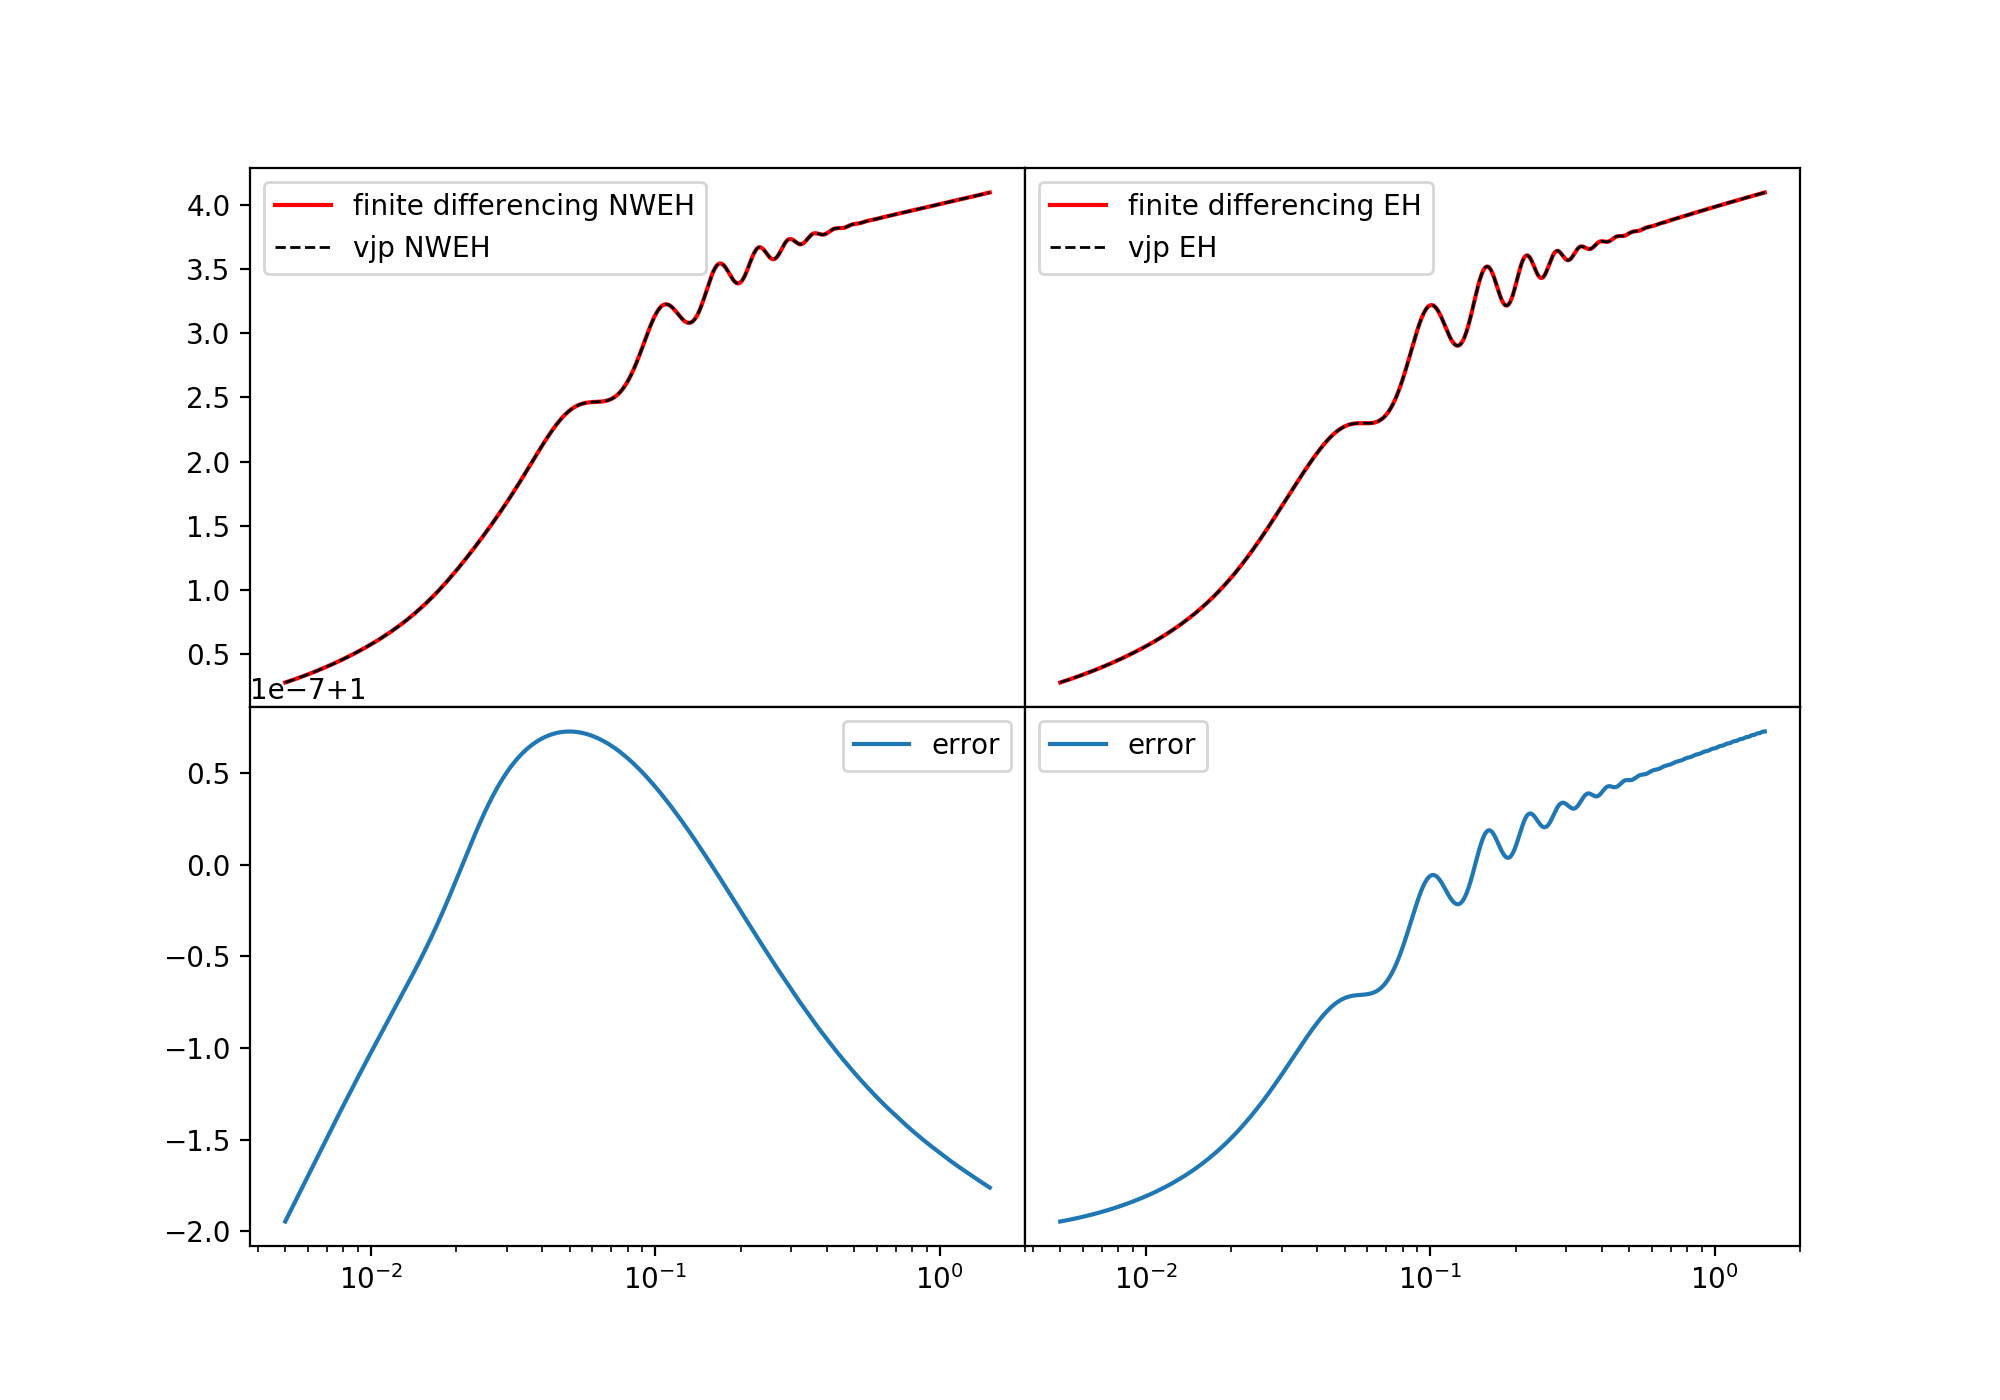

In [45]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=False, gridspec_kw={'hspace':0, 'wspace':0}, figsize=(10,7))
axs[0,0].semilogx(k,test_NWEH*1e6, '-r', label='finite differencing NWEH')
axs[0,0].semilogx(k, vjp_NWEH[0]*1e6, '--k', lw=1, label='vjp NWEH')

axs[1,0].semilogx(k, vjp_NWEH[0]/test_NWEH, label='error')

axs[0,1].semilogx(k,test_EH*1e6, '-r', label='finite differencing EH')
axs[0,1].semilogx(k, vjp_EH[0]*1e6, '--k', lw=1, label='vjp EH')
axs[1,1].semilogx(k, test_EH-vjp_EH[0]/test_EH, label='error')


axs[0,1].set_yticks([])
axs[1,1].set_yticks([])

axs[0,0].legend()
axs[0,1].legend()
axs[1,0].legend()
axs[1,1].legend()

# Z->chi Finite Differencing

In [76]:
from scipy.integrate import quad

In [77]:
def finite_difference(x, delta):
    """
    Forward differencing model for matter density
    """
    om0 = cosmo.Omega0_m
    denom_1 = ((om0+delta/2)*((1+x)**3-1)+1)**(-1/2)
    denom_2 = ((om0-delta/2)*((1+x)**3-1)+1)**(-1/2)
    const = cosmo.C/(delta*cosmo.H0)
    
    
    return const*(denom_1-denom_2)

In [78]:
@autooperator('Omega0_m->chi')
def z_chi(Omega0_m, z, cosmo):
    f= lc.chi_z(Omega0_m, z=z, cosmo=cosmo)
    return dict(chi=f)

In [92]:
vjp = []
for zi in z:
    _, vjpi = z_chi.build(z=zi, cosmo=cosmo).compute_with_vjp(init=dict(Omega0_m=cosmo.Omega0_m), v=dict(_chi=1))
    vjp = np.concatenate((vjp, vjpi))

finite_diff = []
for zi in z:
    finite_diff.append(quad(finite_difference, 0, zi, args = (delta))[0])



<IPython.core.display.Javascript object>


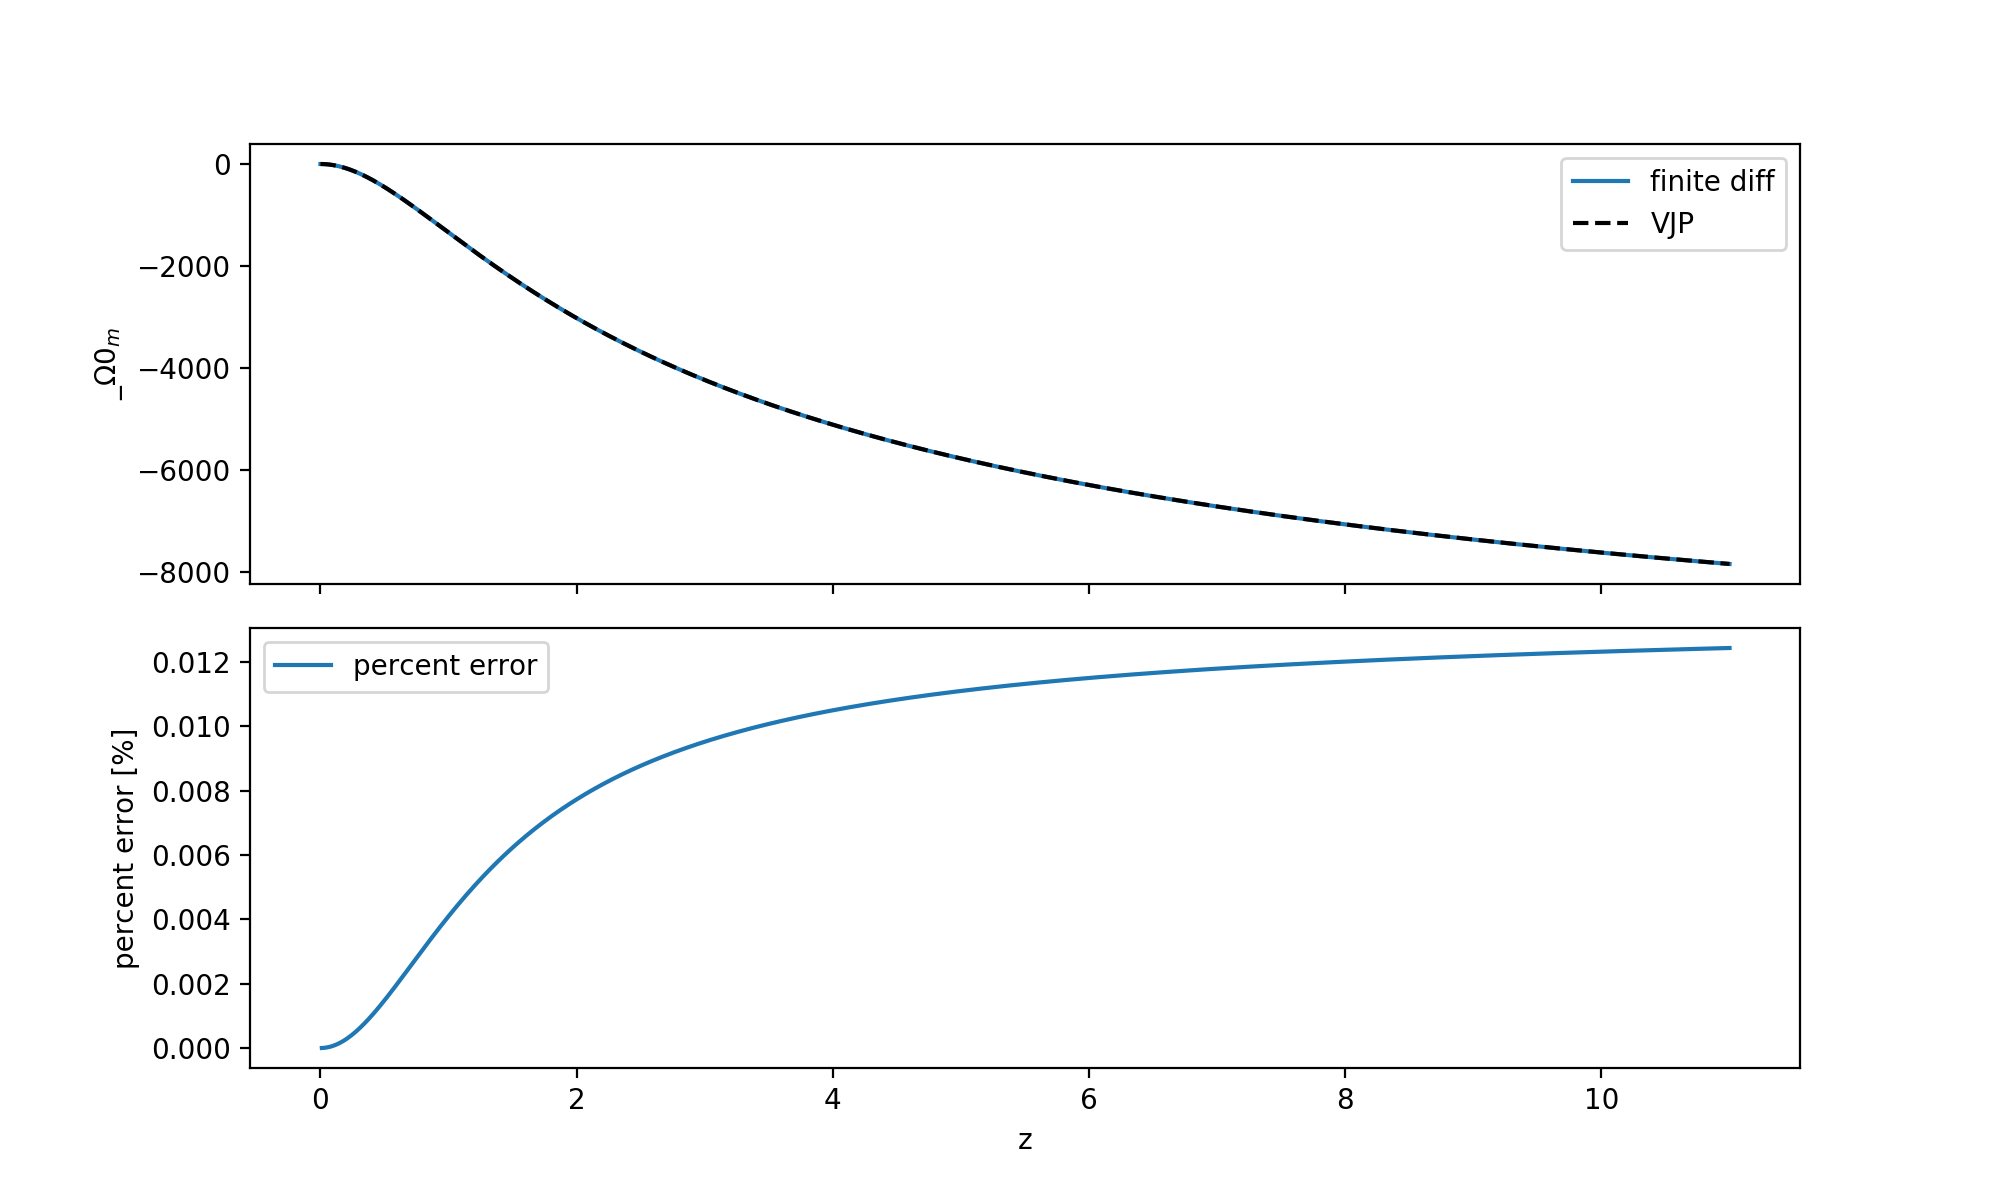

/Users/maxlee/anaconda3/envs/lensing_sim/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [97]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'hspace':.1}, figsize=(10,6))
ax1.plot(z, finite_diff, label='finite diff')
ax1.plot(z, vjp, '--k', label='VJP')
ax1.legend()
ax1.set_ylabel(r'_$\Omega 0_m$')
ax2.set_xlabel('z')


ax2.plot(z, np.asarray(finite_diff-vjp)/finite_diff*100, label='percent error')
ax2.set_ylabel('percent error [%]')
ax2.legend()

plt.legend()